## Elementary Examples in Inverse Dynamics

Falk Mielke, FunMorph, Universiteit Antwerpen

You can download this notebook [here](user://notebooks/ID_LMX5_NLink.ipynb?download&target=_blank).

This is one part of a series of blog posts on Inverse Dynamics.
- [Prologue A: Wrench Town Rock](../id_lmx0a_wrenches)
- [Prologue B: The Fictitious Force Awakens](../id_lmx0b_fforces)
- [Elementary Example 1: Stuttering Motor (Euler Force)](../id_lmx1_stutter)
- [Elementary Example 2: Needle On A Vinyl (Centrifugal Force)](../id_lmx2_vinyl)
- [Elementary Example 3: Radial Slider (Coriolis Force)](../id_lmx3_slider)
- [Elementary Example 4: D'Alambert's Arm (D'Alambert Force)](../id_lmx4_arm)
- [Application: N-Link Inverse Dynamics](../id_lmx5_nlink)

In [1]:
import numpy as NP # numerics
import sympy as SYM # symbolic operations
import sympy.physics.mechanics as MECH # some physics/mechanics tools
import matplotlib.pyplot as MPP # plotting

import WrenchToolbox as WT # contains an improved "Wrench" object

# printing of formulas
SYM.init_printing(use_latex='mathjax', pretty_print = False)
MECH.init_vprinting(use_latex='mathjax', pretty_print = False)

# to disable a current sympy/lambdify/numpy hiccup
from warnings import filterwarnings
filterwarnings('ignore', category=NP.VisibleDeprecationWarning)



# shorthand to get the basis of a reference frame
GetCoordinates = lambda rf: [rf[idx] for idx in rf.indices]

# transforming a sympy vector to a matrix
MatrixToVector = lambda mat, rf: sum([elm * base for elm, base in zip(mat, GetCoordinates(rf)) ])


# Steiner's Theorem, generalized form 
# [modern robotics, page 245]
GeneralizedSteiner = lambda mass, columnvector: \
                        SYM.simplify( \
                             mass * ( (columnvector.T*columnvector)[0] * SYM.eye(3) \
                                      - columnvector*columnvector.T \
                                    ) \
                             )

The custom Wrench Toolbox [can be downloaded here.](http://mielke-bio.info/share/WrenchToolbox.py?download&target=_blank)

# The N-segment piglet limb

This example of inverse dynamics will get us as close to a limb as is good in an educational notebook. 
I focus on the application of the concepts introduced before, and on the code. 
It is an implementation of an "n link" robot arm, or in my case "n segment piglet limb". 
Code is held general, for example the "n" can be adjusted by a single variable. 


<img src="images/id_lmx_nlink.svg" width="500px"> </img>

Focus on a single **segment $i$** along the limb. 
It is connected proximally (proximal direction = limb upwards, if the limb is hanging loose) to segment $i-1$, and the distal adjacent (limb downward) segment is $i+1$. 
They are held at a relative angle $\theta_i(t)$, which is the time-changing angle between the orientation of the proximal adjacent segment and the focal segment.

Joints are points, labeled $P_i$ so that the proximal joint of each segment has the same number $i$. 
Each segment has a center of mass (COM, at point $C_i$), and it might be relevant to know the position vector of $P_i$ to $C_i$. 
The center of mass concentrates a mass $m_i$. 
Segments have a length $l_i$, and for simplicity, the center of mass will always be $\frac{l}{2}$ along the segment. 

Finally, we attach a reference frame to each segment ($\{B\}_i$). 
The segment orientation is fixed in it - or rather the adjacent reference frames are defined to have a relative angle $\theta_i$, and segments are fixed in it. 

All these definitions manifest in the following `sympy` code.


# Generalized Coordinates

This time, I'll use the built-in "dynamic symbols" in `sympy.mechanics`. 
They are functions of time, and the global time variable is `sympy.mechanics.dynamicsymbols._t`. 
Time is a real number, so we first replace the generic time in the module.

In [2]:
# get the time variable for dynamic symbols
t = SYM.symbols('t', real = True)
MECH.dynamicsymbols._t = t



Our system will consist of `n_segments` segments.

In [3]:
# number of segments
n_segments = 3

Because the links are stiff, and fixed to each other at the joints, the angles $\theta$ are useful generalized coordinates.

In [4]:
# angles ...
angles = MECH.dynamicsymbols(f'θ_{{:{n_segments}}}', real = True)

We will also need their time derivatives.

In [5]:
# ... and their time derivatives
angle_velocities = [θ.diff() for θ in angles]
angle_accelerations = [θ.diff().diff() for θ in angles]

angle_accelerations

[θ_{0}'', θ_{1}'', θ_{2}'']

For simplification, set the links to rotate at a steady angular velocity around the joints. 
Though this has nothing to do with actual pig limb motion, it can be used to check whether all the fictitious forces (which become regular) come out as expected.

In [6]:
# here are the periods of rotation for each segment
periods = SYM.symbols(f'T_{{:{n_segments}}}', real = True)

# we fix the angular velocity
# ... and can calculate angle and acceleration from there.
substitutes_θ = {θ: SYM.integrate(2*SYM.pi/T, t) for θ, T in zip(angles, periods)}
substitutes_θdot = {θdot: 2*SYM.pi/T for θdot, T in zip(angle_velocities, periods)}
substitutes_θddot = {θddot: SYM.diff(2*SYM.pi/T, t) for θddot, T in zip(angle_accelerations, periods)}


substitutes = {**substitutes_θ, **substitutes_θdot, **substitutes_θddot}
substitutes

{θ_{0}: 2*pi*t/T_{0}, θ_{1}: 2*pi*t/T_{1}, θ_{2}: 2*pi*t/T_{2}, θ_{0}': 2*pi/T_{0}, θ_{0}'': 0, θ_{1}': 2*pi/T_{1}, θ_{1}'': 0, θ_{2}': 2*pi/T_{2}, θ_{2}'': 0}

These functions could be changed to simulate any kind of movement.
As a homework, you may add Euler or Coriolis components here, as I did in the previous notebooks.

# Constants

We don't include gravity here, but that would in fact be easy. 
The remaining constants are the ones we set: masses and lengths of the segments of our n-link limb.

Each segment has a length and a mass.

In [7]:
# segment length
l = SYM.symbols(f'l_{{:{n_segments}}}', real = True)

# segment mass
m = SYM.symbols(f'm_{{:{n_segments}}}', real = True)

We'll store these constants in a dictionary for subsequent substitution.

In [8]:
constants = {  m[0]: 0.7 # kg \
             , l[0]: 0.8 # m \
             , periods[0]: 2.*SYM.pi #/3. s \
             , m[1]: 0.5 # kg \
             , l[1]: 0.6 # m \
             , periods[1]: 2.*SYM.pi/2. # s \
             , m[2]: 0.3 # kg \
             , l[2]: 0.4 # m \
             , periods[2]: 2.*SYM.pi/4. # s \
             , SYM.pi: NP.pi # = 3.0 \
            }


And here is a function to check equations and elements below.

In [9]:
# this function will substitute and simplify
PlugAllIn = lambda expression: SYM.simplify(SYM.nsimplify(SYM.simplify( \
                                  expression.subs(substitutes).doit().subs(substitutes).doit() \
                                            .subs(constants).subs(constants) \
                                )))

# Reference Frames

The whole system is situated in a static reference frame $\{W\}$ ("world"). 
In addition, each segment will get associated with a reference frame ($\{A\}-\{V\}$).

In [10]:
# static = inertial = world = earth-bound reference frame
world = MECH.ReferenceFrame('W')

frames = [ MECH.ReferenceFrame(list(map(chr, range(ord('A'), ord('W')+0)))[seg]) \
           for seg in range(n_segments+1) \
         ]

# the world is part of a list of frames
allframes = [world] + frames 

# or: as a dict
frames_dict = {str(frame): frame for frame in allframes}
frames_dict

{'W': W, 'A': A, 'B': B, 'C': C, 'D': D}

Because our system is $\hat{x}_1$/$\hat{x}_2$-planar, the relation of the frames is defined by the joint angles around the $\hat{x}_3$ axis. 
To generalize, one could use Quaternions instead of angles. 


In [11]:
# orient all frames by the respective angles
for previous, rf in enumerate(frames[:-1]):
    rf.orient(allframes[previous], 'Axis', (angles[previous], allframes[previous].z))

frames[-1].orient(frames[-2], 'Axis', (0., frames[-2].z))
    
SYM.pprint(PlugAllIn(frames[-1].ang_vel_in(world).to_matrix(world)).T)

[0  0  7.0]


All the transformations between frames are stored in a nested dictionary. 

In [12]:
# "trafo" dict will store transformation matrices "to" any frame "from" another frame.
trafo = {frame: {} for frame in allframes}
for frame_from in allframes:
    for frame_to in allframes:
        trafo[frame_to][frame_from] = SYM.simplify(frame_to.dcm(frame_from))

# display example
PlugAllIn(trafo[world][frames[-1]])

Matrix([
[cos(7*t), -sin(7*t), 0],
[sin(7*t),  cos(7*t), 0],
[       0,         0, 1]])

It is important to note the order of attributes: to transform, select `trafo[to frame][from frame]` or in short 
**`trafo[to][fro]`**. 
For example, to go from the $\{B\}$ frame to the static world $\{W\}$, one would use `trafo[world][B]`.

# Points

Starting from the origin, which coincides with the most proximal joint, we define joints.

In [13]:
### define the origin, i.e. the shoulder
origin = MECH.Point('O')

# the origin does never move
origin.set_vel(world, 0)
origin.set_acc(world, 0)

# n joints plus one end point
joints = [MECH.Point(f'P_{seg}') for seg in range(n_segments+1)]
joints

[P_0, P_1, P_2, P_3]

Despite the `dynamicsymbols` defined above, it is advisible to give `sympy` correct spatial coordinates and derivatives. 

In [14]:

# loop joints
for seg, joint in enumerate(joints):
    ## set position of joint
    if seg == 0:
        # zero'th joint coincides with origin
        joint.set_pos(origin, 0 * world.y)
        # ... and does not move in the world.
        joint.set_vel(world, 0)
        joint.set_acc(world, 0)

    else:
        # all subsequent joints are offset by "length" 
        #   in the y direction of the upchain reference frame 
        joint.set_pos(joints[seg-1], l[seg-1] * frames[seg-1].y)

# re-iterate joints to get the angular derivatives right
for seg, joint in enumerate(joints):
    ## set position derivatives
    for frame in allframes:
        # check whether the frame is associated with the joint
        if frames[seg] == frame:
            # (i) no movement in the associated frame
            joint.set_vel(frame, 0)
            joint.set_acc(frame, 0)
        else:
            # (ii) derivatives in the other frames
            joint.set_vel(frame, joint.pos_from(joints[max([seg-1, 0])])\
                                  .express(frame).diff(t, frame).simplify())
            joint.set_acc(frame, joint.vel(frame).express(frame).diff(t, frame).simplify())

            
# print an example 
joints[1].pos_from(origin).express(world).diff(t, world)

- l_{0}*cos(θ_{0})*θ_{0}'*W.x - l_{0}*sin(θ_{0})*θ_{0}'*W.y

For simplification, the centers of mass are located halfway along a segment. 

In a real setting, one would have to take the real position of the centers of mass relative to joints, and associate another reference frame with the center of mass that is aligned with the principal moments of inertial. 
Here, centers of mass are located in the reference frames defined for the joints.

In [15]:
# center of mass, relative to proximal joint
coms = [MECH.Point(f'C_{seg}') for seg in range(n_segments)]

# fix positions, velocities, accelerations
for seg, com in enumerate(coms):
    # set center of mass position: halfway towards the next joint
    com.set_pos(joints[seg], l[seg]*1./2. * frames[seg].y)
    
    for frame in allframes:
#         # also get the motion derivatives
#         com.set_vel(frame, com.pos_from(joints[seg-1]).express(frame).diff(t, frame).simplify())
#         com.set_acc(frame, com.vel(frame).express(frame).diff(t, frame).simplify())

        # Here, the "v2pt_theory" automatism should work reliably
        com.v2pt_theory(joints[seg], frame, frames[seg])
        

In [16]:
# print an example
coms[1].pos_from(origin).express(world).diff(t, world).simplify()

(-l_{0}*cos(θ_{0})*θ_{0}' - 0.5*l_{1}*(θ_{0}' + θ_{1}')*cos(θ_{0} + θ_{1}))*W.x + (-l_{0}*sin(θ_{0})*θ_{0}' - 0.5*l_{1}*(θ_{0}' + θ_{1}')*sin(θ_{0} + θ_{1}))*W.y

It is important to check whether all positions are correct. 


In [17]:
for j in range(n_segments):
    print('#'*4, j, '#'*4)
    SYM.pprint(joints[j+1].pos_from(joints[j]).express(world).simplify().to_matrix(world).T)
    SYM.pprint((2*(coms[j].pos_from(joints[j]))).express(world).simplify().to_matrix(world).T)
    

#### 0 ####
[-l_{0}⋅sin(θ_{0}(t))  l_{0}⋅cos(θ_{0}(t))  0]
[-1.0⋅l_{0}⋅sin(θ_{0}(t))  1.0⋅l_{0}⋅cos(θ_{0}(t))  0]
#### 1 ####
[-l_{1}⋅sin(θ_{0}(t) + θ_{1}(t))  l_{1}⋅cos(θ_{0}(t) + θ_{1}(t))  0]
[-1.0⋅l_{1}⋅sin(θ_{0}(t) + θ_{1}(t))  1.0⋅l_{1}⋅cos(θ_{0}(t) + θ_{1}(t))  0]
#### 2 ####
[-l_{2}⋅sin(θ_{0}(t) + θ_{1}(t) + θ_{2}(t))  l_{2}⋅cos(θ_{0}(t) + θ_{1}(t) + θ
_{2}(t))  0]
[-1.0⋅l_{2}⋅sin(θ_{0}(t) + θ_{1}(t) + θ_{2}(t))  1.0⋅l_{2}⋅cos(θ_{0}(t) + θ_{1
}(t) + θ_{2}(t))  0]


And also check derivatives:

In [18]:
for j in range(n_segments):
    print('#'*4, j, '#'*4)
    SYM.pprint(PlugAllIn(((joints[j].acc(allframes[j]))).express(world).simplify().to_matrix(world)).T)
    SYM.pprint(PlugAllIn(((coms[j].acc(allframes[j]))).express(world).simplify().to_matrix(world)).T)
    

#### 0 ####
[0  0  0]
⎡2⋅sin(t)  -2⋅cos(t)    ⎤
⎢────────  ──────────  0⎥
⎣   5          5        ⎦
#### 1 ####
[0  0  0]
⎡6⋅sin(3⋅t)  -6⋅cos(3⋅t)    ⎤
⎢──────────  ────────────  0⎥
⎣    5            5         ⎦
#### 2 ####
[0  0  0]
⎡16⋅sin(7⋅t)  -16⋅cos(7⋅t)    ⎤
⎢───────────  ─────────────  0⎥
⎣     5             5         ⎦


# Inertias 

Every segment is associated with point masses at the center of mass. 
Hence, the **Mass Moment of Inertia** $I$ is trivial (zero) at that point. 

However, relative to all other points, we get a *Steiner* component ("parallel axis theorem"), by using the following formula (Lynch and Park, 2017, p. 245): 

$ I_{r} = I_{0} + m \left( r^{T} r \cdot I − r r^{T} \right) $

Where $r$ is the position vector from a reference point $0$ (at which $I_0$ is known) to the new point. Of course, $I$ differs between reference frames, even when seen at the same point.

In [19]:
# zero inertia relative to the com (because we have point masses)
inertia = MECH.inertia(frames[-1], 0, 0, 0)
I = [{} for _ in range(n_segments)]

for seg, com in enumerate(coms):
    # the segment has an inertia at the com, in the segment frame.
    com_inertia = MECH.inertia(frames[seg], 0, 0, 0)
    
    # loop all reference points
    for refpoint in [origin] + coms + joints:
        
        # take stored inertia and add Steiner component
        I[seg][refpoint] = { frames[seg]: \
                          com_inertia.to_matrix(frames[seg])\
                          + GeneralizedSteiner(  m[seg] \
                                     , refpoint.pos_from(com).express(frames[seg]).to_matrix(frames[seg]) \
                                              ) \
                       }

        # all the I's can be transformed to the inertial reference frame
        for other_frame in allframes:
            I[seg][refpoint][other_frame] = \
                        SYM.simplify(trafo[other_frame][frames[seg]] * I[seg][refpoint][frames[seg]] )


An example:

In [20]:
# print an example
PlugAllIn(I[1][joints[1]][world])

Matrix([
[9*cos(3*t)/200, 0,     0],
[9*sin(3*t)/200, 0,     0],
[             0, 0, 9/200]])

This is the mass moment of inertia of the first (not: zero'th) segment, relative to its proximal joint, in the static frame, or: `I[1][joints[1]][world]`.

Generally, the nested inertia `dict` can be accessed as follows: `I[segment id][reference point][ref frame]`. 
It should contain all segments and points, precalculated, or if that is computationally challenging, only the adjacent ones. 


# Kinematics

Once the abstract system is well defined, the aggregation of spatial information should be trivial. 
We will require linear and angular parameters.

In a real experiment, one would take the abstract definitions above, then assemble the numeric values, and plug them into the formulas. 
In our case, we just re-organize the known positions, as symbolic functions of time. 

In [21]:
# shorthands for the derivative levels
p = 0 # zero'th derivative: the position vector
v = 1 # first derivative: the velocity
a = 2 # second derivative: the acceleration

## Linear Kinematics

One part of kinematics is getting the center of mass positions, relative to all other points. 
Again, I will construct a nested dictionary. 

The `sympy` functions `Point.pos_from(other_point)` works as a charm here, even if we would have parametrized this with quaternions. 

In [22]:
# prepare an empty dictionary
x = {}

# loop reference points
for point in [origin] + coms + joints:
    x[point] = {}
        
    # loop focus points
    for refjoint in [origin] + joints:# + coms:
        x[point][refjoint] = {}
        
        # loop reference frames
        for frame in allframes:
            # get position, velocity and acceleration in that frame
            pos = point.pos_from(refjoint).express(frame).simplify().to_matrix(frame)
            vel = SYM.simplify(pos.diff(t))
            acc = SYM.simplify(vel.diff(t))
            
            # ... and store them in the lowest level of the dict
            x[point][refjoint][frame] = { \
                                      p: pos \
                                    , v: vel \
                                    , a: acc \
                                   }



And this can be accessed as follows:

In [23]:
# Recall from previous notebooks: the time derivatives depend on reference frame
SYM.pprint(PlugAllIn(trafo[frames[0]][frames[1]]*x[coms[1]][origin][frames[1]][v]).T)
SYM.pprint(PlugAllIn(x[coms[1]][origin][frames[0]][v]).T)
SYM.pprint(PlugAllIn(trafo[frames[0]][world]*x[coms[1]][origin][world][v]).T)

[1.6  0  0]
⎡-3⋅cos(2⋅t)   -3⋅sin(2⋅t)    ⎤
⎢────────────  ────────────  0⎥
⎣     5             5         ⎦
⎡  9⋅cos(2⋅t)   4  -9⋅sin(2⋅t)    ⎤
⎢- ────────── - ─  ────────────  0⎥
⎣      10       5       10        ⎦


In this dictionary, there are labels to select the `[com]` of interest, a `[reference joint]`, the `[reference frame]`, and finally `[derivative]` (which can be 0, 1 or 2). 
Although all positions could be retrieved, it is sufficient to store positions of centers of mass relative to joints. 
For those relative positions, I found it useful to pre-calculate reference frame transformations and derivatives, although pre-calculation generates some overhead. 

So remember: this reads out as `x[of com][relative to joint][in frame x][derivative]`. 


## Angular Kinematics

For angular kinematics, no points are needed. 
The angular motion, often described by the mysterious greek letter $\omega$, is completely described by the time derivatives of the relative angle of the reference frames. 

In [24]:
# the same dictionary magic as above
ω = {frame: {} for frame in allframes}

## angular positions, exploiting the definitions above
for frame1 in allframes:
    for frame2 in allframes:
        ω[frame2][frame1] = {v: frame1.ang_vel_in(frame2).to_matrix(frame2) \
                            , a: frame1.ang_acc_in(frame2).to_matrix(frame2) \
                            }
        


Example:

In [25]:

# quick check:
SYM.pprint((ω[world][frames[1]][v]).T)
SYM.pprint((ω[world][frames[0]][v]).T)
SYM.pprint((ω[frames[0]][frames[1]][v]).T)
SYM.pprint((ω[frames[1]][frames[1]][v]).T)

⎡      d              d           ⎤
⎢0  0  ──(θ_{0}(t)) + ──(θ_{1}(t))⎥
⎣      dt             dt          ⎦
⎡      d           ⎤
⎢0  0  ──(θ_{0}(t))⎥
⎣      dt          ⎦
⎡      d           ⎤
⎢0  0  ──(θ_{1}(t))⎥
⎣      dt          ⎦
[0  0  0]


This reads: 
`rotation[in frame][of frame][derivative]`. 

This weird notation is helpful, because when transforming between reference frames, subscript cancellation can be applied, for example:

ω<sub>AB</sub> = R<sub>A<s>S</s></sub> ω<sub><s>S</s>B</sub>


Remember that the rotation of a focal frame in another one, transformed to the focal frame, is not necessarily zero: 

$ R_{AS}\omega_{SA} = \omega_{AA} \neq 0 $

So I will rather keep the rotation matrices explicit below (you could write $\omega_{A_sA}$).


# Visualization

Plotting the joint trajectories is always a good idea. 
In this case, I plot the center of mass positions, not the joints.

In [26]:
time = NP.linspace(0., 2*NP.pi, 256, endpoint = False)
joint_positions = [SYM.lambdify(t, PlugAllIn(x[point][origin][world][p]), 'numpy') \
                   for point in coms]

lin_velocity = [SYM.lambdify(t, PlugAllIn(x[point][origin][world][v]), 'numpy') \
                   for point in coms]
lin_acceleration = [SYM.lambdify(t, PlugAllIn(x[point][origin][world][a]), 'numpy') \
                   for point in coms]


In [27]:
y = [pos[0] for pos in joint_positions[-1](time)] 

v_values = lin_velocity[-1](time)


# arrange in arrays of equal lengths
for v_nr, val in enumerate(v_values):
    if (len(val) == 1) and NP.all(NP.sum(NP.abs(val)) == 0):
        v_values[v_nr] = [NP.zeros((len(time),))]
        
# stack velocities
vel = NP.stack([val[0] for val in v_values], axis = 1)

# get a color from v magnitude
v_mag = NP.sqrt(NP.sum(NP.power(vel, 2), axis = 1))
v_cval = v_mag - NP.min(v_mag)

# MPP.plot(time, v_cval);
# MPP.show()

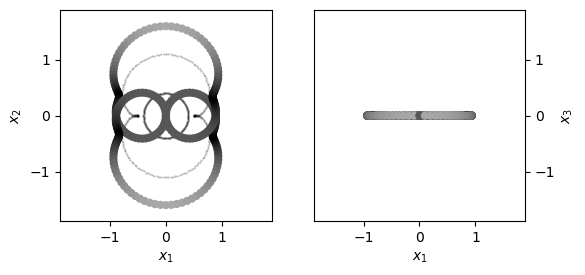

In [28]:
ys = [[pos[0] for pos in position(time)] \
    for position in joint_positions]
y = ys[-1]

fig = MPP.figure(dpi = 100)

ax = fig.add_subplot(1,2,1,aspect = 'equal')
for yj in ys:
    ax.scatter(yj[0], yj[1], s = 2 \
           , color = '0.' \
           , marker = '.' \
           , alpha = 0.2 \
          )
ax.scatter(y[0], y[1], s = 24 \
           , color = [(val, val, val) for val in 0.66*v_cval/NP.max(v_cval)] \
           , marker = 'o' \
           , alpha = 1. \
          )
ax.set_xlim(NP.array([-1.05,1.05])*(sum([constants[seglen] for seglen in l])))
ax.set_ylim(NP.array([-1.05,1.05])*(sum([constants[seglen] for seglen in l])))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(1,2,2,aspect = 'equal')
ax.scatter(y[0], NP.ones((len(y[0]),))*y[2], s = 24 \
           , color = [(val, val, val) for val in 0.66*v_cval/NP.max(v_cval)] \
           , marker = 'o' \
           , alpha = 1. \
          )
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_xlim(NP.array([-1.05,1.05])*(sum([constants[seglen] for seglen in l])))
ax.set_ylim(NP.array([-1.05,1.05])*(sum([constants[seglen] for seglen in l])))
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_3$')

MPP.show();

Maybe I will animate it at some point.

# Inertial Frame Kinetics

Now for the big business: inverse dynamics, using wrenches. 
To start off, let's calculate the distal joint wrench in the inertial frame.


It is good to remember how the data structures were defined above:
- Transformation `trafo[to][fro]`
- Mass Moment of Inertia `I=inertia[of segment][relative to reference point][in reference frame]`
- Linear Kinematics `x=position[of com][relative to joint][in frame x][derivative]`
- Angular Kinematics `ω=rotation[in frame][of frame][derivative]`

Mass, length and period would simply be accessed by `segment id`.

In [29]:
# use shorthands to facilitate accessing the functions.
seg = n_segments-1
com = coms[seg]
joint = joints[seg]
frame = frames[seg]

The **Dynamic Wrench** of the focal segment is the left handside of the balance equation. 
The easiest way of construction is to define it at the center of mass, and then translate it to the proximal segment joint. 

*[update 2020/09/12]* I previously used `x[com][joint][world][a]`, so the rotation of the COM relative to the joint. 
Thereby, I involuntarily canceled D'Alamberts force (now added below), which is the force due to the acceleration of the attachment point of the reference frame. 
Make sure to use `x[com][origin][world][a]` in the static frame, so the actual acceleration of the COM relative to the static origin. 

In [30]:
# dynamic force
dynamic_force_S = m[seg]*x[com][origin][world][a]
SYM.pprint(PlugAllIn(dynamic_force_S).T)

# dynamic moment
dynamic_moment_S = I[seg][com][world]*ω[world][frame][a] \
                    + ω[world][frame][v].cross( I[seg][com][world]*ω[world][frame][v] ) 
SYM.pprint(PlugAllIn(dynamic_moment_S).T)

# assembling the dynamic wrench (at the center of mass)
dynamic_wrench_S = WT.Wrench.FromMatrices(world, com, dynamic_force_S, dynamic_moment_S \
                       )

# because it was assembled at the center of mass, we must translate the wrench to the joint
dynamic_wrench_S = dynamic_wrench_S.Translate(joint)


PlugAllIn(dynamic_wrench_S.Matrix()).T

⎡6⋅sin(t)   81⋅sin(3⋅t)   147⋅sin(7⋅t)    6⋅cos(t)   81⋅cos(3⋅t)   147⋅cos(7⋅t
⎢──────── + ─────────── + ────────────  - ──────── - ─────────── - ───────────
⎣   25           50            50            25           50            50    

)   ⎤
─  0⎥
    ⎦
[0  0  0]


Matrix([[6*sin(t)/25 + 81*sin(3*t)/50 + 147*sin(7*t)/50, -6*cos(t)/25 - 81*cos(3*t)/50 - 147*cos(7*t)/50, 0, 0, 0, 81*sin(4*t)/250 + 6*sin(6*t)/125]])

Now for the right handside. 
We want to calculate the **Joint Wrench**. 
We generate it with placeholders and solve for them below. 

In [31]:
force_components_S = SYM.symbols('f_{JS1:4}', real = True)
moment_components_S = SYM.symbols('m_{JS1:4}', real = True)

joint_wrench_S = WT.Wrench.FromComponents(world, joint, force_components_S, moment_components_S)

SYM.pprint(joint_wrench_S.Matrix().T)


[f_{JS1}  f_{JS2}  f_{JS3}  m_{JS1}  m_{JS2}  m_{JS3}]


These are the only wrenches present in our problem. 
In a real situation, consider adding a tip wrench (at the distal joint) or further other wrenches such as gravity or air drag.

These are all the ingredients for the **Balance of Wrenches**:

In [32]:
# get the equations
equations_S = dynamic_wrench_S.Equate(joint_wrench_S) # simple.

# desired outcome variables
components_S =  [*force_components_S, *moment_components_S]

# extract the solution
solutions = {}
for param, sol in SYM.solve(equations_S \
                           , components_S \
                           ).items():
    solutions[param] = sol

# transform the result into a wrench
W_JS = WT.Wrench.FromMatrix(world, joint, SYM.Matrix([[solutions[cmp]] for cmp in components_S]) )
SYM.pprint(PlugAllIn(W_JS.express(frame).Matrix()).T)

⎡  81⋅sin(4⋅t)   6⋅sin(6⋅t)    81⋅cos(4⋅t)   6⋅cos(6⋅t)   147           81⋅sin
⎢- ─────────── - ──────────  - ─────────── - ────────── - ───  0  0  0  ──────
⎣       50           25             50           25        50               25

(4⋅t)   6⋅sin(6⋅t)⎤
───── + ──────────⎥
0          125    ⎦


This is always good to have. 
And notably, the balance in the inertial frame is independent of fictitious forces; so if all wrenches were defined correctly, the calculation will be our reference. 
However, it might be desirable to also calculate the joint forces in the segment frames. 

# Kinetics in Any Frame

*[update 2020/09/12]* My theoretical considerations made me conclude that I will not need the code below, because fictitious forces in the segment frames will not affect the resulting joint wrenches. 
Nevertheless, I retained this, hoping that it might be useful for someone. 

By "calculate the joint forces in the segment frames", I really mean "calculate in", as opposed to "transform to" a rotating segment reference frame. 
Transformation is trivially done, by left-multiplying the transformation matrix. 
The bonus by really calculating in a reference frame is that one can calculate the fictitious forces. 

When searching for the correct equations, I found that many authors don't explicitly state in which reference frame the symbols are calculated, and how they are transformed if necessary. 
I have ranted about that in previous notebooks. 
If you experienced the same issues, the following **general equations** might help.  


## Equations

The equations can be used to calculate the joint wrench at the proximal joint of a segment $i$ (associated with $\{A\}$) when viewed from the reference frame $\{A\}$. 
Therein, $\{A\}$ can be any frame, for example the static frame $\{S\}$ or the body frame $\{B\}$ itself.


### Position Vector and Angular Vectors

The position vector $r_{PC}$ is the column vector from proximal joint $P$ to center of mass $C$. 
It can be expressed in different reference frames, for example in $\{A\}$, then it is $r_{PC\{A\}}$

The angular position $\omega$ of a reference frame (e.g. $\{B\}$) in another one (e.g. $\{A\}$) is $\omega_{AB}$, and that is implicitly expressed in the frame denoted by the first index, here $\{A\}$. 
Note that usually $\omega_{BA} = -\omega_{AB}$.

Time derivatives are indicated by dots, and you will find first derivatives (e.g. $\dot{r}_{PC\{A\}}$ is linear speed) and second derivatives (e.g. $\ddot{\omega}_{AB}$ is angular acceleration).

### Inertia

The mass moment of inertia **$I$** of the $i$'th segment, relative to joint $P$, expressed in $\{A\}$, is calculated from the inertia at the segment's center of mass $C$ by

$ I_{iP\{A\}} = R_{AB}\cdot\left( I_{iC\{B\}} + m_i \cdot\left( r^{T}_{PC\{B\}} r_{PC\{B\}} \cdot I_{iC\{B\}} - r_{PC\{B\}} r^{T}_{PC\{B\}} \right) \right) $

The second summand in brackets is the Steiner component.

*[update 2020/09/18]* We do not need the Steiner component, because the dynamic wrench is evaluated at the COM. The moment is then changed by the Wrench translation to the joint.

### Left Hand Side: The Dynamic Wrench

The change of momentum and angular momentum of the segment $i$ is summarized by the dynamic wrench, which is best defined at the center of mass $C$. 
Note that the angular kinematics used here are those of the segment ($\{B\}$), attached at the <s>joint (J)</s> COM $C$ (
*[update 2020/09/18]*) and rotating in the static frame ($\{S\}$), but transformed to the calculation frame ($\{A\}$).

$ W_{dyn\{A\}@C} = \left[ m_i \ddot{r}_{JC\{A\}}\ ;\quad I_{iC\{A\}} \cdot\left( R_{AS}\ddot{\omega}_{SB} \right)  + \left( R_{AS}\dot{\omega}_{SB} \right) \times I_{iC\{A\}} \left( R_{AS}\dot{\omega}_{SB} \right) \right] $

This wrench (a six element column vector) is defined at point $C$ and expressed in reference frame $\{A\}$.
It can be translated (i.e. moved) to joint $P$ (or any other point) and transformed (i.e. rotated) to another reference frame (e.g. $\{S\}$) by using the force component $F_{dyn\{A\}}$ to adjust the moment component:

$ W_{dyn\{S\}@P} = R_{SA} \left( W_{dyn\{A\}@C} + \left[ 0 ;\quad r_{JC\{A\}} \times F_{dyn\{A\}} \right] \right) $


Translation and Transformation work analogously for all coming wrenches.


### Right Hand Side: External Wrenches

The change of momentum must be caused by external wrenches.
These are collected on the right hand side of the balance equation.

#### Tip Wrench

In inverse dynamics, we often know the force at the very tip of the system. 
It is either zero (in the swing phase) or known (e.g. by force plate measurement in case of ground reaction forces). 

Either way, it enters the balance equation on the right handside as a six element vector (three force components, three moment components).  



#### D'Alambert Wrench

The D'Alambert Wrench compensates the fact that the dynamic wrench in $\{A\}$ does not include the acceleration of the attachment point $J$ of $\{A\}$ in the world. 
This is once more the "observer" story: a physicist enclosed in a falling elevator will feel their momentum change by a lifting force, and might thereby conclude that they are in a falling elevater. 

$  W_{Dal\{A\}@C} = \left[ -m_i \left(R_{AS}\cdot \ddot{r}_{OJ\{S\}}\right) \ ;\quad 0 \right] $



#### Euler Wrench

The Euler wrench is defined at the center of mass, where its moment component becomes zero:

$  W_{Eul\{A\}@C} = \left[ -m_i \left(R_{AS}\ddot{\omega}_{SA}\right) \times r_{JC\{A\}} \ ;\quad 0 \right] $


For all the fictitious wrenches, angular kinematics refer to the rotation of the calculation frame ($\{A\}$) in the static frame ($\{S\}$), but transformed to the calculation frame ($\{A\}$). 
This is why I had to use $\left(R_{AS}\ddot{\omega}_{SA}\right)$. 
Because all except the D'Alambert Wrench are situated exclusively in the rotating frame, their position vectors (and position vector derivatives) are taken relative to the attachment point (joint $J$) and need not be transformed, so $r_{JC\{A\}}$ is the correct choice. 
These choices are consistent with those used for the dynamic wrench above.

#### Centrifugal Wrench

Analogously, the detailed formula for the centrifugal wrench at $C$ is:

$  W_{Fug\{A\}@C} = \left[ -m_i \left(R_{AS}\dot{\omega}_{SA}\right) \times \left( \left(R_{AS}\dot{\omega}_{SA}\right) \times r_{JC\{A\}} \right) \ ;\quad 0 \right] $

#### Coriolis Wrench

Finally, Coriolis gave us this beautiful formula (don't forget factor 2):

$  W_{Cor\{A\}@C} = \left[ -2m_i \left(R_{AS}\dot{\omega}_{SA}\right) \times \dot{r}_{JC\{A\}} \ ;\quad 0 \right] $




#### Joint Wrench
 
The Joint Wrench is the sum of all unknown external wrenches that acted on the body, evaluated at the proximal joint of the segment. 
It is the quantity we are interested in.
An accurate determination of the joint wrench requires all wrenches to be known (see below).



#### Other External Wrenches

Other external wrenches have to be added, for example the gravitational wrench, which acts on the center of mass. 

$ W_{grav\{S\}@C} = \left[ m_{i} g \ ;\quad 0 \right] $

Friction can occur (either in the joints, or in interaction with the surrounding medium) and can be added if a plausible model can be inferred.


However, note that one should strive to include all such effects. 
If ignoring the friction wrench, it will nevertheless enter the equation on the left handside because it is a real external effect affecting the dynamics. 
Hence, **external wrenches that are not explicitly modeled will be part of the Joint Wrench.**

For illustration, imagine working under gravity, but forgetting the gravitational wrench. 
If one sees a segment of the limb swing due to gravity, an observer unaware of gravity would think that the joints produce the observed movement by a joint wrench. 


## Computation

The calculation above might be repeated several times, which is a good indication that a function can be defined to facilitate the procedure. 
Following the calculations outlined in previous notebooks, and given the system definition above, here is the general function to calculate the joint wrench of a selected segment, in a selected frame. 

*[update 2020/09/12]* In correction of the initial version, I included D'Alambert wrench. To balance it on the dynamic side, dynamic force was corrected. Finally, I included an "attachment" point to make more explicit why the joint is chosen for some parts of the calculation. 

In [33]:
def Kinetics(segment_id, observer_frame = None, tip_wrench = None, verbose = True):
    # This function calculates the joint wrench for a given segment, with the system defined above.
    # The user has to specify a segment id, and can also give a frame of calculation; default is the segment frame
    
    
    # store the observer_frame of the focal segment
    segment_frame = frames[segment_id]
    com = coms[segment_id]
    joint = joints[segment_id]
    
    
    if observer_frame is None:
        observer_frame = segment_frame
    
    # select an attachment point, which is the distal joint of the observer segment
#     attachment = joints[allframes.index(observer_frame)]
    attachment = origin if observer_frame == world else joints[allframes.index(observer_frame)]
    
    # if no tip wrench is given, use a zero wrench
    if tip_wrench is None:
        tip_wrench = WT.Wrench(observer_frame, joints[segment_id+1])
    
    
### Dynamic Wrench
    # dynamic force
    dynamic_force = m[segment_id]*x[com][attachment][observer_frame][a] 

    # dynamic moment
    omega_dot = trafo[observer_frame][world] * ω[world][segment_frame][v]
    omega_ddot = trafo[observer_frame][world] * ω[world][segment_frame][a]
    # [update 2020/09/18] I is taken relative to the COM
    
    dynamic_moment = SYM.simplify(I[segment_id][com][observer_frame]*omega_ddot \
                                  + omega_dot.cross(I[segment_id][com][observer_frame]*omega_dot) \
                                 )
    if verbose: 
        print(f'\nDynamic wrench of {com} in {observer_frame} frame:')
        SYM.pprint(PlugAllIn(dynamic_moment).T)

    # assembling the dynamic wrench
    dynamic_wrench = WT.Wrench.FromMatrices(observer_frame, com, dynamic_force, dynamic_moment \
                           )

    # Translate wrench from center of mass to joint
    dynamic_wrench = dynamic_wrench.Translate(joint)

    if verbose: 
        SYM.pprint(PlugAllIn(dynamic_wrench.Matrix()).T)
    
### Joint Wrench
    force_components = SYM.symbols(f'f_{{J{segment_frame}in{observer_frame}1:4}}', real = True)
    moment_components = SYM.symbols(f'm_{{J{segment_frame}in{observer_frame}1:4}}', real = True)

    joint_wrench = WT.Wrench.FromComponents(observer_frame, joint, force_components, moment_components)

    if verbose: 
        SYM.pprint(joint_wrench.Matrix().T)
    
    components =  [*force_components, *moment_components]
    
### Fictitious Wrenches
    if verbose:
        print(f'\nFictitious forces of {joint}/{segment_frame} frame in {observer_frame} frame:')
        
    ## D'Alambert    
    dalambert_wrench = WT.Wrench(observer_frame, com \
                         , MatrixToVector(-m[segment_id] \
                                          * (trafo[observer_frame][world] * x[attachment][origin][world][a]) \
                                          , observer_frame ) \
                                ).Translate(joint)
    if verbose: 
        SYM.pprint(PlugAllIn(dalambert_wrench.Matrix()).T)
        
    ## Euler
    euler_wrench = WT.Wrench(observer_frame, com \
                    , MatrixToVector(-m[segment_id]*(trafo[observer_frame][world] * ω[world][observer_frame][a] \
                                                        ).cross(x[com][attachment][observer_frame][p]) \
                                     , observer_frame) \
                     ).Translate(joint)

    if verbose: 
        SYM.pprint(PlugAllIn(euler_wrench.Matrix()).T)
    
    ## Centrifugal
    omega_dot = trafo[observer_frame][world] * ω[world][observer_frame][v]
    centrifugal_wrench = WT.Wrench(observer_frame, com \
                        , MatrixToVector( \
                                 -m[segment_id]*(omega_dot).cross( \
                                                      (omega_dot).cross(x[com][attachment][observer_frame][p]) \
                                                 ) \
                                         , observer_frame) \
                         ).Translate(joint)

    if verbose: 
        SYM.pprint(PlugAllIn(centrifugal_wrench.Matrix()).T)
    
    ## Coriolis
    coriolis_wrench = WT.Wrench(observer_frame, com \
            , MatrixToVector(-2*m[segment_id]*(trafo[observer_frame][world] * ω[world][observer_frame][v] \
                                                  ).cross(x[com][attachment][observer_frame][v]), observer_frame) \
             ).Translate(joint)

    if verbose: 
        SYM.pprint(PlugAllIn(coriolis_wrench.Matrix()).T)
    
### Tip Wrench
    tip_wrench = tip_wrench.Translate(joint)
    
### Equations
    equations = dynamic_wrench.Equate( \
                                        joint_wrench  \
                                      + dalambert_wrench \
                                      + euler_wrench  \
                                      + centrifugal_wrench  \
                                      + coriolis_wrench  \
                                      + tip_wrench \
                                     ) 
    
    if False:
        # used for debugging
        print(f"\n dynamic_wrench at {dynamic_wrench['P']} in the {dynamic_wrench['R']} frame:")
        SYM.pprint(PlugAllIn(dynamic_wrench.express(segment_frame).Matrix()).T)
        
        print(f"\n joint_wrench at {joint_wrench['P']} in the {joint_wrench['R']} frame:")
        SYM.pprint(PlugAllIn(joint_wrench.express(segment_frame).Matrix()).T)
        
        print(f"\n dalambert_wrench at {dalambert_wrench['P']} in the {dalambert_wrench['R']} frame:")
        SYM.pprint(PlugAllIn(dalambert_wrench.express(segment_frame).Matrix()).T)
        
        print(f"\n euler_wrench at {euler_wrench['P']} in the {euler_wrench['R']} frame:")
        SYM.pprint(PlugAllIn(euler_wrench.express(segment_frame).Matrix()).T)
        
        print(f"\n centrifugal_wrench at {centrifugal_wrench['P']} in the {centrifugal_wrench['R']} frame:")
        SYM.pprint(PlugAllIn(centrifugal_wrench.express(segment_frame).Matrix()).T)
        
        print(f"\n coriolis_wrench at {coriolis_wrench['P']} in the {coriolis_wrench['R']} frame:")
        SYM.pprint(PlugAllIn(coriolis_wrench.express(segment_frame).Matrix()).T)
        
        print(f"\n tip_wrench at {tip_wrench['P']} in the {tip_wrench['R']} frame:")
        SYM.pprint(PlugAllIn(tip_wrench.express(segment_frame).Matrix()).T)
        
    

### Solve
    solutions = {}
    for param, sol in SYM.solve(equations \
                               , components \
                               ).items():
        solutions[param] = sol

    W_J = WT.Wrench.FromMatrix(observer_frame, joint, SYM.Matrix([[solutions[cmp]] for cmp in components]) )
    if verbose: 
        print(f'\nWrench at {joint} in the {segment_frame} frame:')
        SYM.pprint(PlugAllIn(W_J.express(segment_frame).Matrix()).T)
        
    return W_J, {'D': dalambert_wrench, 'E': euler_wrench, 'Cf': centrifugal_wrench, 'Cor': coriolis_wrench}

The first useful way to use this function is to calculate the joint wrench of the distalmost segment. 
As a bonus, calculation can be performed in an arbitrary reference frame. 

In [34]:
seg = n_segments-1 # calculate distalmost segment...
rf = frames[seg-1] # from upstream adjacent segment.

# here the calculation is performed, displaying intermediate results
W_J, fictitious_wrenches = Kinetics(seg, rf, verbose = True)

print(f'\nresult wrench at P_{seg}, calculated in the {rf} frame:')
SYM.pprint(PlugAllIn(W_J.Matrix()).T)


Dynamic wrench of C_2 in B frame:
[0  0  0]
⎡24⋅sin(4⋅t)  -24⋅cos(4⋅t)             ⎤
⎢───────────  ─────────────  0  0  0  0⎥
⎣     25            25                 ⎦
[f_{JCinB1}  f_{JCinB2}  f_{JCinB3}  m_{JCinB1}  m_{JCinB2}  m_{JCinB3}]

Fictitious forces of P_2/C frame in B frame:
⎡6⋅sin(2⋅t)  6⋅cos(2⋅t)   81             81⋅sin(4⋅t)   6⋅sin(6⋅t)⎤
⎢──────────  ────────── + ──  0  0  0  - ─────────── - ──────────⎥
⎣    25          25       50                 250          125    ⎦
[0  0  0  0  0  0]
⎡-27⋅sin(4⋅t)   27⋅cos(4⋅t)            ⎤
⎢─────────────  ───────────  0  0  0  0⎥
⎣      50            50                ⎦
⎡-36⋅sin(4⋅t)   36⋅cos(4⋅t)            ⎤
⎢─────────────  ───────────  0  0  0  0⎥
⎣      25            25                ⎦

Wrench at P_2 in the C frame:
⎡  81⋅sin(4⋅t)   6⋅sin(6⋅t)    81⋅cos(4⋅t)   6⋅cos(6⋅t)   147           81⋅sin
⎢- ─────────── - ──────────  - ─────────── - ────────── - ───  0  0  0  ──────
⎣       50           25             50           25       

Check with the static frame calculation:

In [35]:
SYM.pprint((PlugAllIn(W_JS.express(frames[seg]).Matrix())-PlugAllIn(W_J.express(frames[seg]).Matrix())).T)

[0  0  0  0  0  0]


In [36]:

SYM.pprint(SYM.simplify((W_JS.express(frames[seg])-W_J.express(frames[seg])).Matrix()).T)

[0  0  0  0  0  0]


Note that there was no `PlugAllIn`, so the check is true zero.

# Wrenching Up The Chain

The second useful use case is actual inverse dynamics. 
Make sure to start at the tip, and iterate up to the most proximal joint.
At each joint, remember to apply Newton's Last Law `newton_laws[-1]` (usually the third one, but I keep forgetting the order).

In [37]:
seg = n_segments-1
W_tip, _ = Kinetics(seg, verbose = False)
SYM.pprint(PlugAllIn(W_tip.Matrix()).T)

⎡  81⋅sin(4⋅t)   6⋅sin(6⋅t)    81⋅cos(4⋅t)   6⋅cos(6⋅t)   147           81⋅sin
⎢- ─────────── - ──────────  - ─────────── - ────────── - ───  0  0  0  ──────
⎣       50           25             50           25        50               25

(4⋅t)   6⋅sin(6⋅t)⎤
───── + ──────────⎥
0          125    ⎦


In [38]:
seg = n_segments-2
W_J, sample_fictitious = Kinetics(  seg \
                  , tip_wrench = W_tip.express(frames[seg])*-1 \
                  , verbose = False \
                 )


SYM.pprint(PlugAllIn(W_tip.express(frames[seg]).Matrix()).T)
SYM.pprint(PlugAllIn(W_J.Matrix()).T)

⎡  6⋅sin(2⋅t)   147⋅sin(4⋅t)    6⋅cos(2⋅t)   147⋅cos(4⋅t)   81           81⋅si
⎢- ────────── + ────────────  - ────────── - ──────────── - ──  0  0  0  ─────
⎣      25            50             25            50        50               2

n(4⋅t)   6⋅sin(6⋅t)⎤
────── + ──────────⎥
50          125    ⎦
⎡  16⋅sin(2⋅t)   147⋅sin(4⋅t)    16⋅cos(2⋅t)   147⋅cos(4⋅t)   297           33
⎢- ─────────── + ────────────  - ─────────── - ──────────── - ───  0  0  0  ──
⎣       25            50              25            50        100             

⋅sin(2⋅t)   36⋅sin(4⋅t)   6⋅sin(6⋅t)⎤
───────── - ─────────── + ──────────⎥
  125            25          125    ⎦


We can look at the fictitious wrenches on the way, for example the centrifugal wrench:

In [39]:
SYM.pprint(PlugAllIn(sample_fictitious['D'].Matrix()).T )

⎡2⋅sin(2⋅t)  2⋅cos(2⋅t)   27           -3⋅sin(2⋅t) ⎤
⎢──────────  ────────── + ──  0  0  0  ────────────⎥
⎣    5           5        10                25     ⎦


Next segment:

In [40]:
seg = n_segments-3
if not(seg < 0):
    W_O, _ = Kinetics(  seg \
                      , tip_wrench = W_J.express(frames[seg])*-1 \
                      , verbose = False \
                     )

    SYM.pprint(PlugAllIn(W_J.express(frames[seg]).Matrix()).T)
    SYM.pprint(PlugAllIn(W_O.Matrix()).T)

⎡297⋅sin(2⋅t)   147⋅sin(6⋅t)    297⋅cos(2⋅t)   147⋅cos(6⋅t)   16           33⋅
⎢──────────── + ────────────  - ──────────── - ──────────── - ──  0  0  0  ───
⎣    100             50             100             50        25              

sin(2⋅t)   36⋅sin(4⋅t)   6⋅sin(6⋅t)⎤
──────── - ─────────── + ──────────⎥
 125            25          125    ⎦
⎡297⋅sin(2⋅t)   147⋅sin(6⋅t)    297⋅cos(2⋅t)   147⋅cos(6⋅t)   23             2
⎢──────────── + ────────────  - ──────────── - ──────────── - ──  0  0  0  - ─
⎣    100             50             100             50        25              

64⋅sin(2⋅t)   36⋅sin(4⋅t)   288⋅sin(6⋅t)⎤
─────────── - ─────────── - ────────────⎥
   125             25           125     ⎦


... and so forth.

Note how each segment adds its inertia, so the equation becomes longer in the process.

# Summary

These were actual inverse dynamics calculations! 
Some simplifications have made this manageable for symbolic computation and for my simple mind, but could be reverted easily in a numeric world:
- gravity was neglected (just add a wrench for it)
- planar setting (instead, one could relate reference frames by quaternions)
- trivial inertia's (one could use real matrices, though) 
- no friction (how dare me)
- kinematics were analytically determined

However, all the ingredients are there. 

The bonus using the tools above is that we got the fictitious forces at each element of the chain. 
Even D'Alambert's contribution. 





So please, feel free to [download this notebook](user://notebooks/ID_LMX5_NLink.ipynb?download&target=_blank), adjust it, play around with it, and calculate your own inverse dynamics problems. 
And feel free to contact me if you encounter anything which does not work as expected! 

<hr>

# Further Reading

- **Dumas**, R., Aissaoui, R., & de Guise, J. A. (**2004**). *A 3D generic inverse dynamic method using wrench notation and quaternion algebra.* Computer methods in biomechanics and biomedical engineering, 7(3), 159-166. [https://doi.org/10.1080/10255840410001727805](https://doi.org/10.1080/10255840410001727805?target=_blank)

- **Dumas**, R. (**2019**). *3D Kinematics and Inverse Dynamics* , [MATLAB Central File Exchange](https://www.mathworks.com/matlabcentral/fileexchange/58021-3d-kinematics-and-inverse-dynamics?target=_blank). Accessed July 1, 2020. 

- **Lynch**, K. M., & Park, F. C. (**2017**). *Modern Robotics.* Cambridge University Press. ISBN 9781107156302. [http://www.modernrobotics.org](http://www.modernrobotics.org?target=_blank) 

- **Meurer** A., Smith C.P., Paprocki M., Čertík O., Kirpichev S.B., Rocklin M., Kumar A., Ivanov S., Moore J.K., Singh S., Rathnayake T., Vig S., Granger B.E., Muller R.P., Bonazzi F., Gupta H., Vats S., Johansson F., Pedregosa F., Curry M.J., Terrel A.R., Roučka Š., Saboo A., Fernando I., Kulal S., Cimrman R., Scopatz A. (**2017**). *SymPy: symbolic computing in Python.* PeerJ Computer Science 3:e103 [https://doi.org/10.7717/peerj-cs.103](https://doi.org/10.7717/peerj-cs.103?target=_blank)

- **Moore**, J., McMurry, R., Milam, B. (**2016**). *Simulating Robot, Vehicle, Spacecraft, and Animal Motion.* SciPy 2016 Tutorial. [https://www.youtube.com/watch?v=r4piIKV4sDw](https://www.youtube.com/watch?v=r4piIKV4sDw?target=_blank). Accessed July 1, 2020.

- **Owen**, F. (undated). *Rotating reference frame and the five-term acceleration equation*. Alpha Omega Engineering, Inc. [web document](http://www.aoengr.com/Dynamics/RotatingReferenceFrame.pdf?target=_blank). Accessed July 1, 2020.

<hr>

# Errata / Updates
**[2020/09/12]** I realized that I had omitted D'Alamberts Force on both sides of the Balance Equation. I amended this here, and added an extra notebook with another elementary example. Changed passages are indicated in the text. 

**[2020/09/18]** The Moment of Inertia was relative to the joint in a previous version. It should be relative to the COM, because the dynamic wrench is calculated at the COM.